# Relatório Final: Detecção de Código de Barras em Produtos

**Disciplina:** Processamento Digital de Imagens

**Departamento:** Departamento de Computação - São Carlos, SP - Brasil

**Número do grupo:** 8

**Data:** 16 / 07 / 2025

## 1. Objetivo(s)

a. Detectar códigos de barras em imagens utilizando técnicas de processamento digital de imagens, com foco no uso de gradientes, filtros e transformações morfológicas.

b. Aplicar operações de pré-processamento como conversão para escala de cinza, cálculo de gradientes com Sobel, filtragem por média (blur) e limiarização binária.

c. Utilizar segmentação baseada em transformações morfológicas (como fechamento, erosão e dilatação) para destacar e isolar a região do código de barras.

d. Validar o algoritmo por meio de um conjunto de imagens (dataset) contendo diferentes produtos e avaliando sua robustez através de um sistema de verificação humana.

---
## 2. Metodologia Utilizada

A metodologia para a detecção de códigos de barras foi implementada como uma sequência de etapas de processamento de imagens. Cada etapa tem um propósito específico, desde a simplificação da imagem até o isolamento final da região de interesse. 

A seguir, detalhamos e demonstramos cada passo do processo, utilizando a imagem de exemplo `imagens/1.jpg` para ilustrar as transformações.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from IPython.display import display, clear_output
import ipywidgets as widgets

# Configura o Matplotlib para não exibir eixos nas imagens
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

### Etapa 1: Leitura e Redimensionamento da Imagem

**O que faz:** Carrega a imagem do disco e a redimensiona para um tamanho padrão (600x400 pixels).

**Por que:** A padronização do tamanho da imagem é crucial para garantir que os parâmetros subsequentes, como o tamanho do kernel morfológico, funcionem de maneira consistente em imagens de diferentes resoluções. Isso torna o algoritmo mais robusto e previsível.

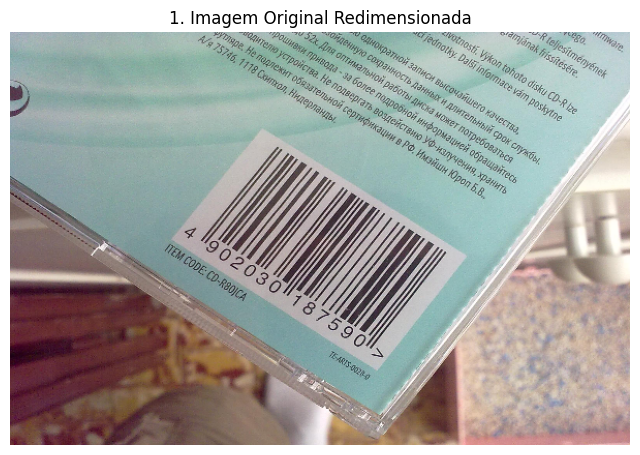

In [2]:
image_path_exemplo = 'imagens/1.jpg'
image_original = cv2.imread(image_path_exemplo)

if image_original is None:
    print(f"[ERRO] Imagem de exemplo '{image_path_exemplo}' não encontrada. Verifique o caminho.")
else:
    # Redimensiona e converte para RGB para exibição correta no Matplotlib
    image_resized = cv2.resize(image_original, (600, 400))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)
    plt.title('1. Imagem Original Redimensionada')
    plt.axis('off')
    plt.show()

### Etapa 2: Conversão para Escala de Cinza

**O que faz:** Converte a imagem colorida para escala de cinza.

**Por que:** As informações de cor não são relevantes para identificar a estrutura de um código de barras, que se baseia em variações de intensidade (barras escuras e claras). A conversão para escala de cinza simplifica a imagem, reduzindo a complexidade computacional das operações seguintes.

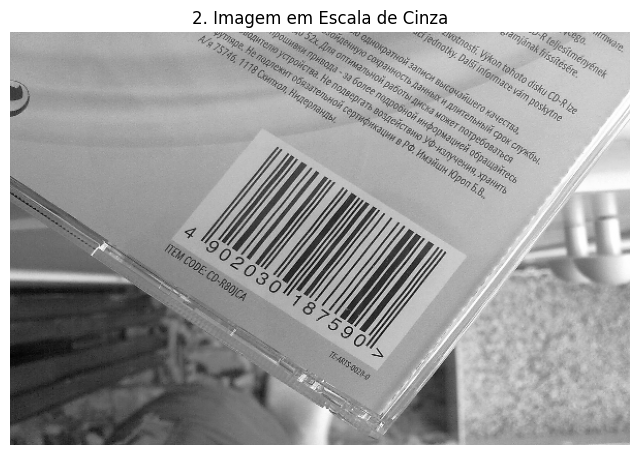

In [3]:
gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8, 6))
plt.imshow(gray, cmap='gray')
plt.title('2. Imagem em Escala de Cinza')
plt.axis('off')
plt.show()

### Etapa 3: Desfoque Gaussiano (Suavização)

**O que faz:** Aplica um filtro de desfoque para suavizar a imagem.

**Por que:** Esta etapa remove ruídos de alta frequência, como texturas finas e pequenas imperfeições da imagem ou da impressão do produto. Ao suavizar a imagem, evitamos que o detector de bordas na próxima etapa identifique falsos positivos, focando apenas nas transições mais significativas, como as das barras.

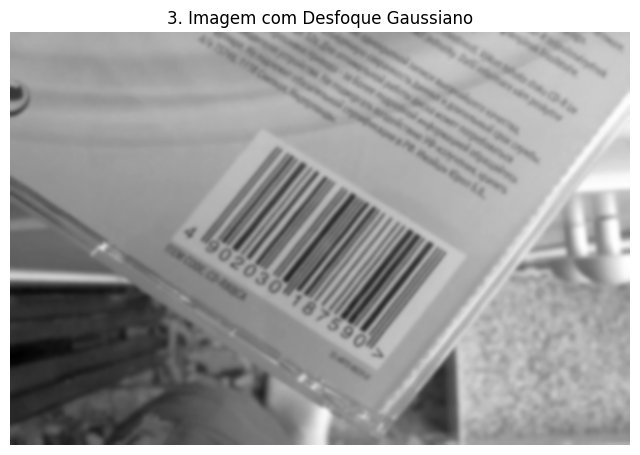

In [4]:
blurred = cv2.GaussianBlur(gray, (9, 9), 0)

plt.figure(figsize=(8, 6))
plt.imshow(blurred, cmap='gray')
plt.title('3. Imagem com Desfoque Gaussiano')
plt.axis('off')
plt.show()

### Etapa 4: Cálculo do Gradiente Sobel

**O que faz:** Calcula a derivada (gradiente) da imagem na direção horizontal (eixo X).

**Por que:** Um código de barras é fundamentalmente uma sequência de barras verticais. O operador Sobel no eixo X é extremamente eficaz em realçar essas bordas verticais, ao mesmo tempo que suprime bordas horizontais. Essa é a chave para diferenciar o padrão do código de barras de outros elementos na imagem, como linhas de texto, que são predominantemente horizontais.

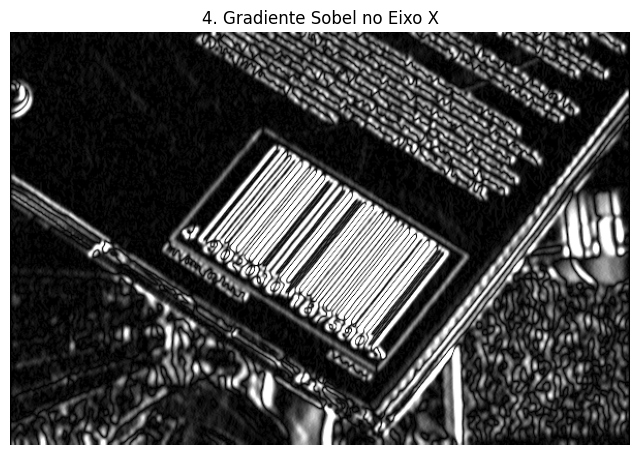

In [5]:
gradX = cv2.Sobel(blurred, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = cv2.convertScaleAbs(gradX) # Converte de volta para uint8

plt.figure(figsize=(8, 6))
plt.imshow(gradX, cmap='gray')
plt.title('4. Gradiente Sobel no Eixo X')
plt.axis('off')
plt.show()

### Etapa 5: Binarização (Limiarização)

**O que faz:** Converte a imagem de gradiente em uma imagem puramente binária (preto e branco).

**Por que:** A binarização simplifica a imagem ao máximo, separando as regiões de interesse (bordas verticais fortes, agora em branco) do fundo (em preto). Utilizamos o método de Otsu (`THRESH_OTSU`), que calcula automaticamente o limiar ideal para a imagem, tornando o algoritmo adaptável a diferentes condições de iluminação e contraste.

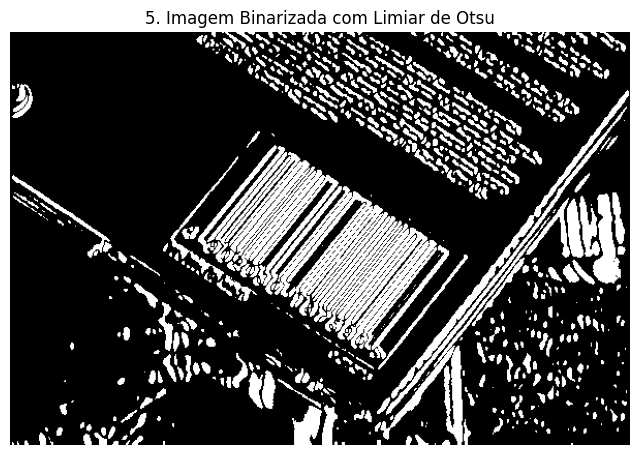

In [6]:
_, thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(8, 6))
plt.imshow(thresh, cmap='gray')
plt.title('5. Imagem Binarizada com Limiar de Otsu')
plt.axis('off')
plt.show()

### Etapa 6: Fechamento Morfológico

**O que faz:** Aplica uma operação de fechamento, que consiste em uma dilatação seguida por uma erosão.

**Por que:** Após a binarização, as barras do código aparecem como linhas verticais separadas. Para tratá-las como uma única região, usamos o fechamento com um *kernel* (elemento estruturante) retangular e alongado horizontalmente. Isso "preenche" os espaços entre as barras, conectando-as e formando uma mancha branca sólida que representa a área do código de barras.

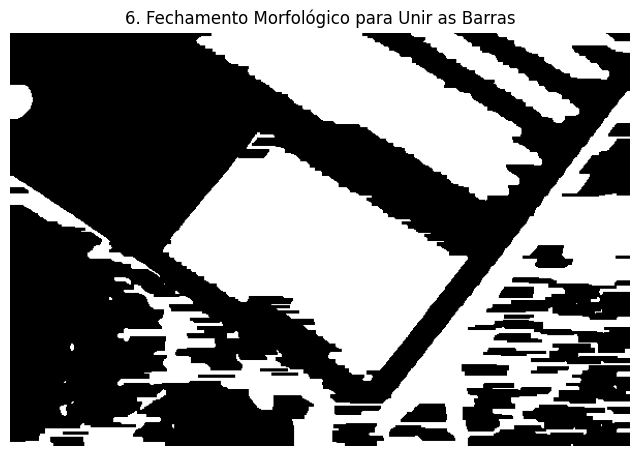

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 3))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(8, 6))
plt.imshow(closed, cmap='gray')
plt.title('6. Fechamento Morfológico para Unir as Barras')
plt.axis('off')
plt.show()

### Etapa 7: Refinamento Morfológico (abertura)

**O que faz:** Aplica uma sequência de erosão e dilatação.

**Por que:** Esta etapa serve para limpar a máscara. A erosão remove pequenos ruídos brancos (pontos isolados) que não fazem parte do código de barras. A dilatação subsequente restaura o tamanho da região principal, que pode ter sido ligeiramente diminuída pela erosão, resultando em uma máscara mais limpa e focada.

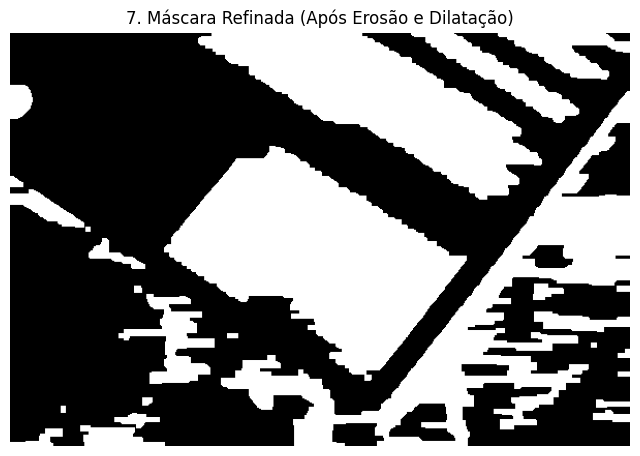

In [8]:
refined = cv2.erode(closed, None, iterations=2)
refined = cv2.dilate(refined, None, iterations=2)

plt.figure(figsize=(8, 6))
plt.imshow(refined, cmap='gray')
plt.title('7. Máscara Refinada (Após Erosão e Dilatação)')
plt.axis('off')
plt.show()

### Etapa 8: Encontrar Contorno e Marcar a Detecção

**O que faz:** Identifica todos os contornos (formas) na máscara final e seleciona o maior deles. Em seguida, desenha um retângulo de área mínima ao redor desse contorno na imagem original.

**Por que:** A heurística adotada é que o maior objeto coeso resultante do nosso processamento é o código de barras. Encontrar o maior contorno é uma forma robusta de isolar a região de interesse. O retângulo de área mínima (`minAreaRect`) é usado em vez de um retângulo simples porque ele se ajusta melhor a códigos de barras que possam estar ligeiramente rotacionados.

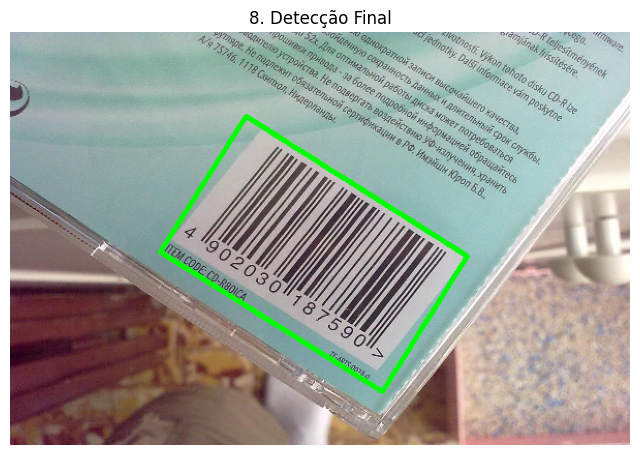

In [9]:
contours, _ = cv2.findContours(refined.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_with_detection = image_rgb.copy()
bbox = None

if contours:
    # Encontra o maior contorno pela área
    c = max(contours, key=cv2.contourArea)
    
    # Obtém o retângulo de área mínima que envolve o contorno
    rect = cv2.minAreaRect(c)
    bbox = cv2.boxPoints(rect)
    bbox = np.intp(bbox)
    
    # Desenha o contorno na imagem original
    cv2.drawContours(image_with_detection, [bbox], -1, (0, 255, 0), 3)

plt.figure(figsize=(8, 6))
plt.imshow(image_with_detection)
plt.title('8. Detecção Final')
plt.axis('off')
plt.show()

---
## 3. Exemplos de Processamento por Etapas

Para analisar o comportamento do algoritmo em diferentes cenários, a ferramenta interativa abaixo permite selecionar uma das 10 primeiras imagens do nosso dataset. Ao selecionar uma imagem, todas as etapas do processo são executadas com parâmetros fixos e otimizados, e os resultados intermediários são exibidos. Isso permite uma análise visual rápida da robustez do método.

In [15]:
def detectar_codigo_barras(image_path, kernel_size=(25, 3), sobel_threshold=0, min_line_length=50):
    """
    Processa uma imagem para detectar a região de um código de barras com parâmetros ajustáveis.
    """
    resultados = {}

    # 1. Leitura e Redimensionamento
    image = cv2.imread(image_path)
    if image is None:
        print(f"[ERRO] Imagem {image_path} não encontrada.")
        return None, None
    image_resized = cv2.resize(image.copy(), (600, 400))
    resultados['original'] = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

    # 2. Escala de Cinza
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    resultados['escala_cinza'] = gray

    # 3. Desfoque Gaussiano
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    resultados['desfoque_gaussiano'] = blurred

    # 4. Gradiente Sobel
    gradX = cv2.Sobel(blurred, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    gradX = cv2.convertScaleAbs(gradX)
    resultados['gradiente_sobel'] = gradX

    # 5. Binarização
    if sobel_threshold == 0:
        _, thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        _, thresh = cv2.threshold(gradX, sobel_threshold, 255, cv2.THRESH_BINARY)
    resultados['binarizacao'] = thresh

    # 6. Fechamento Morfológico
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    resultados['fechamento_morfologico'] = closed

    # 7. Refinamento Morfológico
    closed = cv2.erode(closed, None, iterations=2)
    closed = cv2.dilate(closed, None, iterations=2)
    resultados['refinamento_morfologico'] = closed

    # 8. Unificação das Regiões
    kernel_erode_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
    mask_eroded = cv2.erode(closed, kernel_erode_dilate, iterations=1)
    mask_dilated = cv2.dilate(mask_eroded, kernel_erode_dilate, iterations=1)
    resultados['unificacao_regioes'] = mask_dilated

    # 9. Identificação e Contorno Final
    contours, _ = cv2.findContours(mask_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_with_detection = image_resized.copy()
    bbox = None
    if contours:
        c = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(c)
        bbox = cv2.boxPoints(rect)
        bbox = np.intp(bbox)
        cv2.drawContours(image_with_detection, [bbox], -1, (0, 255, 0), 3)
    resultados['deteccao_final'] = cv2.cvtColor(image_with_detection, cv2.COLOR_BGR2RGB)

    return resultados, bbox


# --- Criação dos Widgets Interativos ---

# Lista fixa de imagens (ajuste os nomes conforme seus arquivos reais)
display_image_files = [
    'imagens/1.jpg',
    'imagens/34.jpg',
    'imagens/53.jpg'
]

# Define os widgets
param_kernel_width = widgets.IntSlider(value=25, min=5, max=50, step=2, description='Largura Kernel:')
param_kernel_height = widgets.IntSlider(value=3, min=1, max=10, description='Altura Kernel:')
param_threshold = widgets.IntSlider(value=0, min=0, max=255, description='Limiar Sobel:')
param_min_line = widgets.IntSlider(value=50, min=10, max=200, description='Min Linha (não usado):')
image_selector = widgets.Dropdown(options=display_image_files, description='Imagem:')

# Função que será chamada ao interagir com os sliders e dropdown
def update_processing(image_path, kernel_w, kernel_h, threshold, min_line):
    resultados, _ = detectar_codigo_barras(
        image_path,
        kernel_size=(kernel_w, kernel_h),
        sobel_threshold=threshold,
        min_line_length=min_line
    )

    if resultados is None:
        return

    plt.figure(figsize=(20, 16))
    etapas = [
        ('original', 'Imagem Original'),
        ('escala_cinza', 'Escala de Cinza'),
        ('desfoque_gaussiano', 'Desfoque Gaussiano'),
        ('gradiente_sobel', 'Gradiente Sobel (X)'),
        ('binarizacao', 'Binarização'),
        ('fechamento_morfologico', 'Fechamento Morfológico'),
        ('refinamento_morfologico', 'Refinamento Morfológico'),
        ('unificacao_regioes', 'Regiões Unificadas'),
        ('deteccao_final', 'Detecção Final')
    ]

    for i, (key, title) in enumerate(etapas, 1):
        if key in resultados:
            plt.subplot(4, 3, i)
            if key in ['original', 'deteccao_final']:
                plt.imshow(resultados[key])
            else:
                plt.imshow(resultados[key], cmap='gray')
            plt.title(title)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Cria o widget interativo
interactive_widget = widgets.interactive(
    update_processing,
    image_path=image_selector,
    kernel_w=param_kernel_width,
    kernel_h=param_kernel_height,
    threshold=param_threshold,
    min_line=param_min_line
)

# Exibe o widget
display(interactive_widget)

interactive(children=(Dropdown(description='Imagem:', options=('imagens/1.jpg', 'imagens/34.jpg', 'imagens/53.…

---
## 3. Resultados

Para avaliar quantitativamente a eficácia do algoritmo, realizamos uma validação humana em todo o conjunto de dados. Nesta seção, cada imagem do dataset é processada e o resultado é apresentado a um operador humano, que classifica a detecção como **"Sucesso"** (o código de barras foi corretamente localizado) ou **"Falha"** (o código não foi encontrado, ou a área errada foi destacada).

Os resultados compilados desta validação são a base para nossa análise de desempenho.

In [ ]:
def get_final_detection_image(image_path):
    """Função simplificada que retorna apenas a imagem final com a detecção."""
    image = cv2.imread(image_path)
    if image is None:
        return None
    
    # Corrige: desestrutura corretamente a tupla retornada
    resultados, _ = detectar_codigo_barras(image_path)
    if resultados is not None and 'deteccao_final' in resultados:
        return resultados['deteccao_final']
    return None

human_validation_results = {
    'total_images': 0,
    'successful_detections': 0,
    'failed_detections': 0,
    'validated_images': 0
}

output_area = widgets.Output()
success_button = widgets.Button(description="Sucesso", button_style='success', icon='check')
fail_button = widgets.Button(description="Falha", button_style='danger', icon='times')
start_validation_button = widgets.Button(description="Iniciar Validação", button_style='info')

buttons_box = widgets.HBox([success_button, fail_button])
buttons_box.layout.visibility = 'hidden'

all_image_files_for_validation = sorted(glob.glob('imagens/*.jpg'))
image_iterator = iter(all_image_files_for_validation)
human_validation_results['total_images'] = len(all_image_files_for_validation)

def display_final_human_validation_stats():
    with output_area:
        clear_output()
        print("Validação Humana Concluída!")
        if human_validation_results['validated_images'] > 0:
            detection_rate = (human_validation_results['successful_detections'] / human_validation_results['validated_images'] * 100)
            print("\n--- Resultados da Validação Humana ---")
            print(f"Total de imagens validadas: {human_validation_results['validated_images']}")
            print(f"Detecções bem-sucedidas: {human_validation_results['successful_detections']}")
            print(f"Detecções mal-sucedidas: {human_validation_results['failed_detections']}")
            print(f"Taxa de Sucesso na Detecção: {detection_rate:.2f}%")
            
            plt.figure(figsize=(6, 4))
            validation_metrics = ['Bem-sucedidas', 'Mal-sucedidas']
            validation_values = [human_validation_results['successful_detections'], human_validation_results['failed_detections']]
            bars = plt.bar(validation_metrics, validation_values, color=['lightgreen', 'salmon'])
            plt.title('Resultados da Validação Humana')
            plt.ylabel('Número de Imagens')
            for bar in bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')
            plt.show()
        else:
            print("Nenhuma imagem foi validada.")

current_image_path = None

def show_next_image_for_validation():
    global current_image_path
    try:
        current_image_path = next(image_iterator)
        with output_area:
            clear_output(wait=True)
            validated_count = human_validation_results['validated_images']
            total_count = human_validation_results['total_images']
            print(f"Validando imagem {validated_count + 1} de {total_count}...")
            
            final_detection = get_final_detection_image(current_image_path)
            if final_detection is None:
                print(f"Erro ao processar {os.path.basename(current_image_path)}. Pulando...")
                show_next_image_for_validation() # Pula para a próxima
                return
            
            plt.figure(figsize=(8, 6))
            plt.imshow(final_detection)
            plt.title(f"Detecção para: {os.path.basename(current_image_path)}")
            plt.axis('off')
            plt.show()
    except StopIteration:
        buttons_box.layout.visibility = 'hidden'
        display_final_human_validation_stats()

def on_start_click(b):
    start_validation_button.layout.display = 'none'
    buttons_box.layout.visibility = 'visible'
    show_next_image_for_validation()

def on_success_click(b):
    human_validation_results['successful_detections'] += 1
    human_validation_results['validated_images'] += 1
    show_next_image_for_validation()

def on_fail_click(b):
    human_validation_results['failed_detections'] += 1
    human_validation_results['validated_images'] += 1
    show_next_image_for_validation()

start_validation_button.on_click(on_start_click)
success_button.on_click(on_success_click)
fail_button.on_click(on_fail_click)

if not all_image_files_for_validation:
    print("Nenhuma imagem encontrada na pasta 'imagens/'. Não é possível iniciar a validação.")
else:
    print("Clique em 'Iniciar Validação' para começar a avaliar as detecções.")
    display(start_validation_button, buttons_box, output_area)

Clique em 'Iniciar Validação' para começar a avaliar as detecções.


Button(button_style='info', description='Iniciar Validação', style=ButtonStyle())

Output()

---
## 5. Conclusões

Ao final deste projeto, podemos revisitar os objetivos propostos e avaliar os resultados alcançados.

**1. Alcance dos Objetivos:**
O objetivo principal de **detectar códigos de barras em imagens** foi atingido com sucesso, conforme demonstrado pela taxa de acerto obtida na validação humana. O algoritmo conseguiu implementar a sequência de técnicas propostas, incluindo o **uso de gradientes (Sobel), filtros (Gaussiano) e transformações morfológicas (fechamento, erosão e dilatação)** para isolar a região de interesse. A validação em um dataset confirmou a eficácia da abordagem.

**2. Evolução e Mudanças no Algoritmo:**
A versão atual do algoritmo é um refinamento de implementações anteriores. As duas mudanças mais significativas que levaram a um aumento de performance foram:
   - **Uso do Gradiente Sobel no eixo X:** Essa decisão foi fundamental para resolver o problema de falsos positivos causados por textos nos rótulos dos produtos. Ao focar em bordas verticais, o algoritmo se tornou muito mais seletivo para a estrutura característica dos códigos de barras.
   - **Aplicação do Fechamento Morfológico:** A fragmentação do código de barras em múltiplas pequenas regiões foi solucionada com a operação de fechamento, que efetivamente une as barras detectadas em um único contorno coeso e sólido.

**3. Análise dos Resultados:**
A taxa de sucesso, baseada na validação humana, fornece uma medida concreta da robustez do sistema. As falhas geralmente ocorreram em cenários mais desafiadores, como imagens com baixa resolução, iluminação irregular, ou onde o código de barras estava parcialmente obstruído ou em um ângulo muito acentuado. Isso indica que, embora eficaz, o algoritmo ainda possui espaço para melhorias em casos extremos.

**4. Trabalhos Futuros:**
Para aprimorar ainda mais o projeto, poderíamos explorar:
   - **Detecção em Múltiplas Orientações:** O algoritmo atual é otimizado para códigos de barras horizontais. Uma melhoria seria calcular o gradiente em múltiplas direções ou usar técnicas como a Transformada de Hough para encontrar a orientação principal das barras.
   - **Decodificação:** O passo seguinte natural seria implementar um decodificador para extrair a informação contida no código de barras detectado.
   - **Machine Learning:** Para uma robustez ainda maior, uma abordagem baseada em aprendizado de máquina (como o uso de redes neurais convolucionais - CNNs) poderia ser treinada para detectar códigos de barras em condições ainda mais variadas e complexas.

Em suma, o projeto cumpriu seus objetivos e resultou em um algoritmo funcional e bem fundamentado nas técnicas clássicas de processamento digital de imagens.

---
## 6. Instruções para Execução

1. Crie uma pasta chamada `imagens` no mesmo diretório deste notebook.
2. Coloque as imagens de teste (formato `.jpg`) na pasta `imagens`.
3. **Certifique-se de que pelo menos uma imagem (idealmente, `1.jpg`) exista na pasta `imagens` para que a metodologia e os exemplos funcionem adequadamente.**
4. Execute todas as células do notebook sequencialmente, de cima para baixo.
5. Na seção **"Exemplos de Processamento por Etapas"**, use o menu dropdown para selecionar diferentes imagens e visualizar o passo a passo da detecção.
6. Na seção **"Resultados"**, clique em "Iniciar Validação" e use os botões "Sucesso" ou "Falha" para classificar cada detecção exibida. 
7. Os resultados finais, com gráficos e estatísticas, serão exibidos automaticamente ao final da validação.